<a href="https://colab.research.google.com/github/kuntal14/Uderstanding_LangGraph/blob/main/LangGraph00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basics

In [1]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph #this is where the agent state will be stored


In [2]:
# we create agentState that will be used to store the state of the agent at any point in time
class AgentState(TypedDict): #state schema
  message : str

In [5]:
# any node takes in the state of the agent and modifies it, so input and output is agent state
def greeting_node(state : AgentState) -> AgentState:
  # add doc strings everywhere
  """Simple node that adds ..first checkpoint... to the input message"""
  state['message'] = "Hey, " + state["message"] + " this is the first checkpoint."

  return state

In [7]:
graph = StateGraph(AgentState)

graph.add_node("greeter", greeting_node)

In [10]:
# this is where we define the starting and ending point of the graph
graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

In [11]:
#compoile the graph
app = graph.compile()

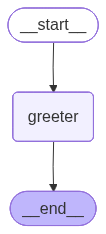

In [12]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [13]:
result = app.invoke({"message" : "Kuntal"})

In [15]:
result["message"]

'Hey, Kuntal this is the first checkpoint.'

# **Multiple Input**

In [16]:
from typing import List

In [17]:
class AgentState(TypedDict):
  values: List[int]
  name : str
  result : str

In [19]:
def process_values(state : AgentState) -> AgentState:
  """This is a function that handles multiple different inputs"""

  state["result"] = f"Hi there {state["name"]}! Your sum of List is = {sum(state["values"])}"

  return state

In [21]:
graph = StateGraph(AgentState)

graph.add_node("sum of list",process_values)

In [22]:
graph.set_entry_point("sum of list")
graph.set_finish_point("sum of list")

In [24]:
app = graph.compile()

In [31]:
ans = app.invoke({"values" : [1,2,3],"name" : "Kuntal","result" : ""})

In [32]:
ans["result"]

'Hi there Kuntal! Your sum of List is = 6'

# Sequential Graph

In [34]:
class AgentState(TypedDict):
  name : str
  age : str
  final : str


In [35]:
def first_node(state : AgentState) -> AgentState:
  """This is the first node of our sequence"""

  state["final"] = f"Hey {state["name"]}!"

  return state

def second_node(state: AgentState) -> AgentState:
  """this is the second node of our sequence"""

  state["final"] = state["final"] + f"YOu are {state["age"]} years old"

  return state

In [38]:
graph = StateGraph(AgentState)

graph.add_node("first",first_node)
graph.add_node("second",second_node)

graph.set_entry_point("first")
graph.add_edge("first", "second")
graph.set_finish_point("second")

app = graph.compile()

In [39]:
app.invoke({
    "name" : "Kuntal",
    "age" : "22",
    "final" : ""
})

{'name': 'Kuntal', 'age': '22', 'final': 'Hey Kuntal!YOu are 22 years old'}

# Conditional Graph

In [40]:
from langgraph.graph import START, END

In [52]:
class AgentState(TypedDict):
  number1 : int
  operation : str
  number2 : int
  finalNumber : int

In [53]:
def adder(state: AgentState) -> AgentState:
  """"this node adds the 2 numbers"""

  state["finalNumber"] = state["number1"] + state["number2"]

  return state

def subtractor(state: AgentState) -> AgentState:
  """"this node adds the 2 numbers"""

  state["finalNumber"] = state["number1"] - state["number2"]

  return state

In [59]:
def decide_next_node(state:AgentState) -> AgentState:
  """this will decide the next node"""

  if state["operation"] == "+":
    return "addition_operation"
  elif state["operation"] == "-":
    return "subtraction_operation"

In [60]:
graph = StateGraph(AgentState)

graph.add_node("add_node", adder)
graph.add_node("sub_node", subtractor)
graph.add_node("router", lambda state:state)

graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router",
    decide_next_node,
    {
        # Edge : node
        "addition_operation" : "add_node",
        "subtraction_operation" : "sub_node"
    }
)

graph.add_edge("add_node", END)
graph.add_edge("sub_node", END)


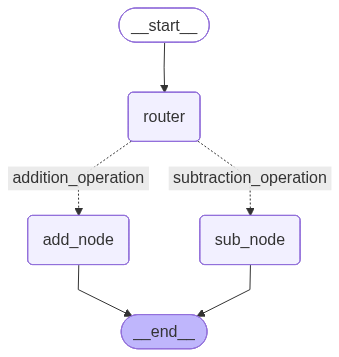

In [61]:
graph.compile()

In [62]:
app = graph.compile()

In [63]:
initial_state_1 = AgentState(number1 = 10, operation="-", number2 = 5)
print(app.invoke(initial_state_1))

{'number1': 10, 'operation': '-', 'number2': 5, 'finalNumber': 5}


# Looping Graph


In [65]:
import random

In [89]:
class AgentState(TypedDict):
  name:str
  number : List[int]
  counter : int

In [96]:
def greeting_node(state : AgentState) -> AgentState:
  """Greeting Node whihc says hi"""
  state["name"] = f"Hi, there, {state["name"]}"
  state["counter"] = 0

  return state

def random_node(state : AgentState) -> AgentState:
  """Generates a random Number"""
  state["number"].append(random.randint(0, 10))
  state["counter"] += 1

  return state

def should_continue(state: AgentState) -> AgentState:
  """Function to decide what to do next"""

  if state["counter"] < 5:
    print("ENTERING LOOP", state["counter"])
    return "loop" # continue looping
  else:
    return "exit" # Exit the loop

In [97]:
# greeting -> random -> random -> random -> random -> random -> END

In [98]:
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)

graph.add_edge("greeting", "random")
graph.add_edge(START, "greeting")

# add condnl edges

graph.add_conditional_edges(
    "random", # source where the decesion will be taken
    should_continue,
    {
        "loop" : "random",
        "exit" : END # end the graph
    }

)

# graph.set_entry_point("greeting")



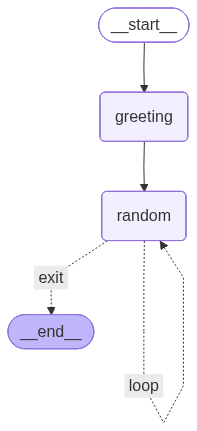

In [99]:
graph.compile()

In [100]:
app = graph.compile()

In [101]:
app.invoke({
    "name" : "Kuntal",
    "number" : [],
    "counter" : 0
})

ENTERING LOOP 1
ENTERING LOOP 2
ENTERING LOOP 3
ENTERING LOOP 4


{'name': 'Hi, there, Kuntal', 'number': [8, 0, 10, 4, 5], 'counter': 5}